# CS336 Assignments

| # | Topic                         | Description                                 |
|---|-------------------------------|---------------------------------------------|
| 1 | Basics                        | Train an LLM from scratch                   |
| 2 | Systems                       | Make it run fast!                           |
| 3 | Scaling                       | Make it performant at a FLOP budget         |
| 4 | Data                          | Prepare the right datasets                  |
| 5 | Alignment & Reasoning RL      | Align it to real-world use cases            |

# Assignment #1
- Implement all of the components (tokenizer, model, loss function, optimizer) necessary to train a standard Transformer language model
- Train a minimal language model

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import lovely_tensors as lt
lt.monkey_patch()

import tiktoken

from datasets import load_dataset

## cross entropy loss

In [17]:
def crossentropyloss(actuals, preds):
    probs = preds.squeeze().sigmoid()
    eps = 1e-8
    loss = - actuals * (probs + eps).log() - (1 - actuals) * ((1 - probs) + eps).log()
    return loss.mean()


In [24]:
torch.manual_seed(42)
preds = torch.randn(1, 5)
actuals = torch.tensor([1, 1, 0, 0, 1])

crossentropyloss(actuals, preds)

tensor 0.841

In [35]:
bce = torch.nn.BCEWithLogitsLoss()
bce(preds.squeeze(), actuals.float())

tensor 0.841

In [40]:
ce = torch.nn.CrossEntropyLoss()
ce(preds.flatten(), actuals.float())

tensor 5.709

## AdamW optimizer

In [141]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = torch.optim.AdamW(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

In [142]:
n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9260
step:   2 | loss:  0.9234
step:   3 | loss:  0.9207
step:   4 | loss:  0.9181
step:   5 | loss:  0.9155
step:   6 | loss:  0.9129
step:   7 | loss:  0.9103
step:   8 | loss:  0.9077
step:   9 | loss:  0.9051


## Our own AdamW optimizer implementation
Now, let's implement the AdamW optimizer!

In [146]:
class AdamW_custom:
    def __init__(self, params, lr=3e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        self.params = params
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.wd = weight_decay
        self.eps = eps
        self.step_count = 0

        # Initialize momentum and velocity for each parameter
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        pass

    def step(self):
        pass

In [147]:
torch.zeros_like(torch.tensor(5))

tensor i64 0

In [148]:
torch.zeros(5)

tensor[5] all_zeros [0., 0., 0., 0., 0.]

In [149]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = AdamW_custom(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

In [150]:
n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9286
step:   2 | loss:  0.9286
step:   3 | loss:  0.9286
step:   4 | loss:  0.9286
step:   5 | loss:  0.9286
step:   6 | loss:  0.9286
step:   7 | loss:  0.9286
step:   8 | loss:  0.9286
step:   9 | loss:  0.9286


Clearly, the network is not learning anything as our optimizer is not updating the weights. Let's go ahead and fill up the implementation.

In [151]:
class AdamW_custom:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.wd = weight_decay
        self.eps = eps
        self.step_count = 0

        # Initialize momentum and velocity for each parameter
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.step_count += 1

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data

            # Apply weight decay directly to parameters (AdamW style)
            param.data.mul_(1 - self.lr * self.wd)

            # Update biased first moment estimate
            # beta1 * i + (1-beta2) * grad
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta2) * grad

            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad.pow(2)
            
            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1 ** self.step_count)

            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[i] / (1 - self.beta2 ** self.step_count)

            # Update parameters
            param.data.add_(m_hat * -self.lr/ (v_hat.sqrt() + self.eps))

        # print(sum([p for p in self.params]))



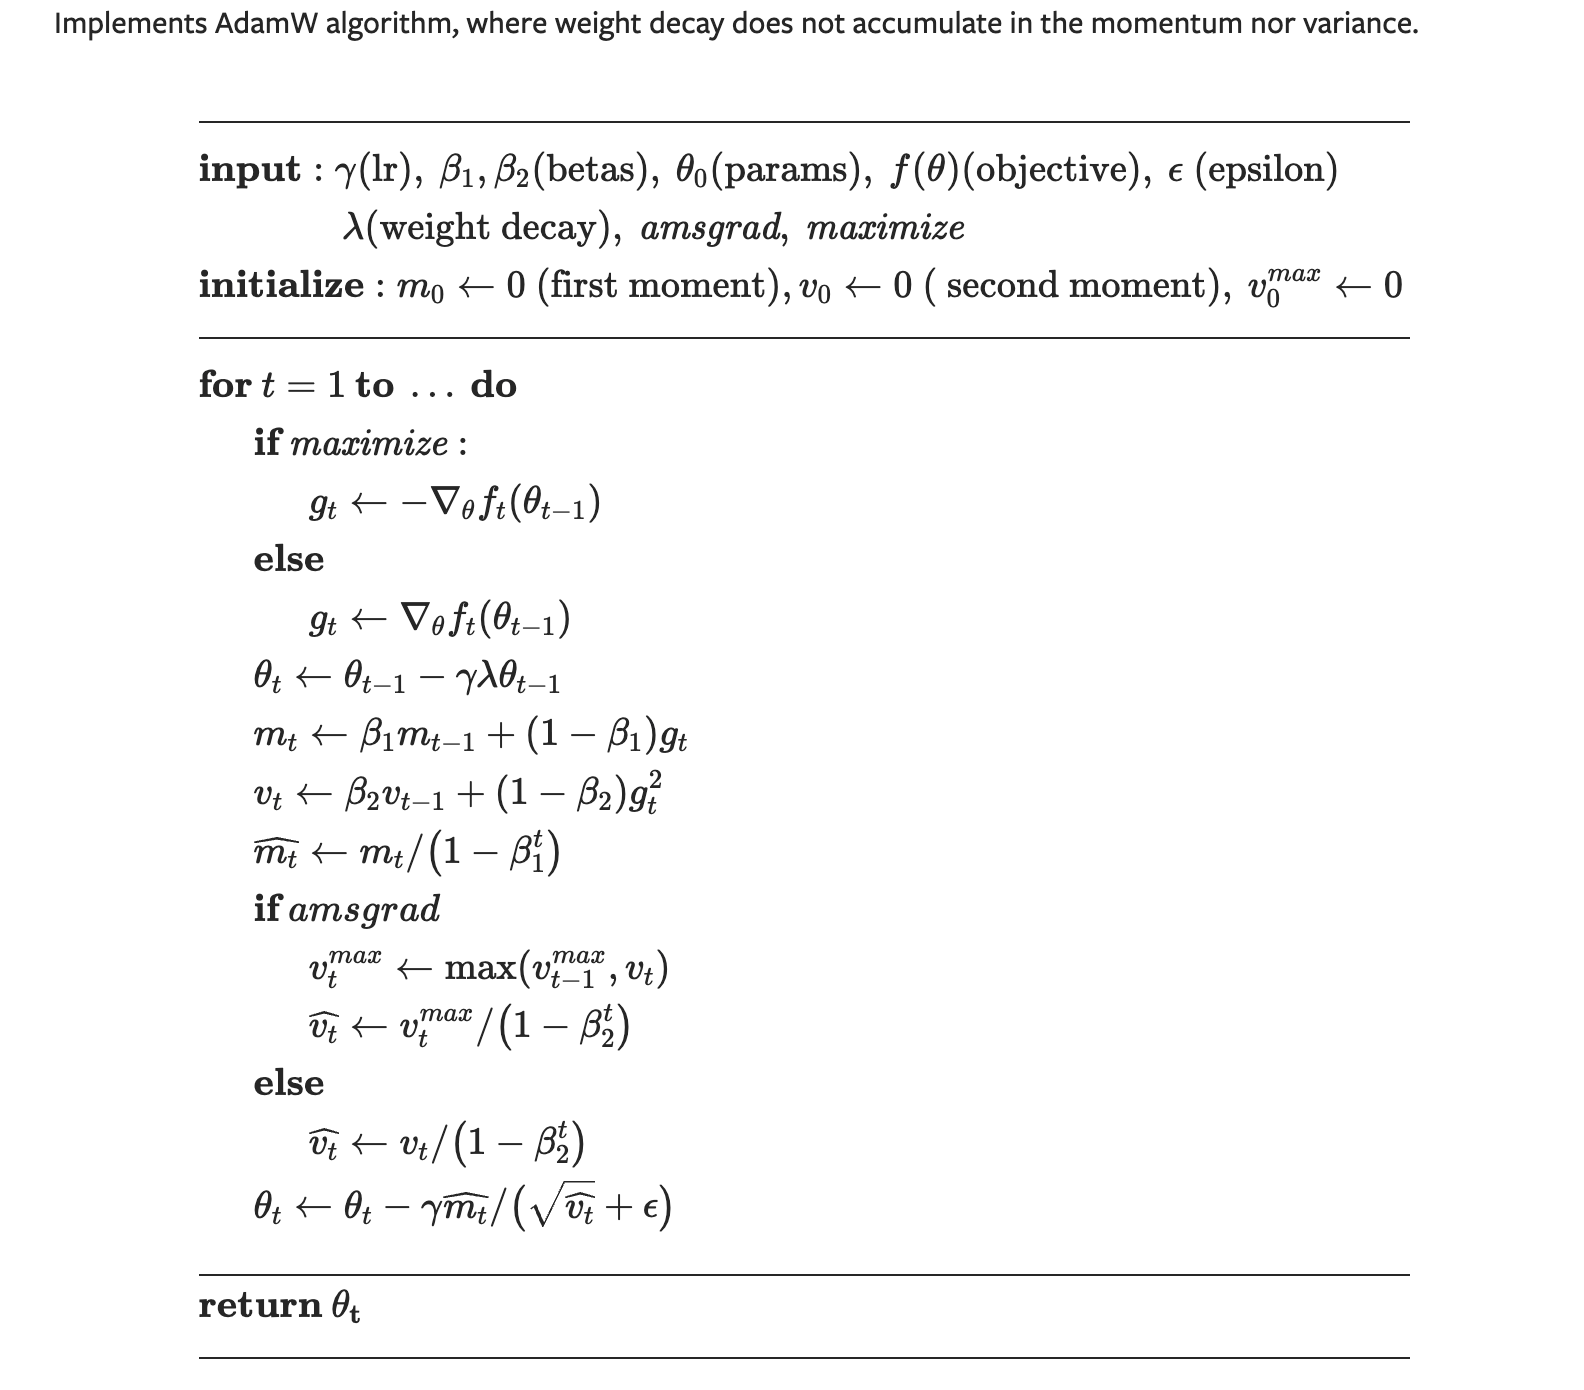

In [152]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = AdamW_custom(model.parameters())
# optimizer = torch.optim.AdamW(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9286
step:   2 | loss:  0.9286
step:   3 | loss:  0.9285
step:   4 | loss:  0.9285
step:   5 | loss:  0.9285
step:   6 | loss:  0.9285
step:   7 | loss:  0.9284
step:   8 | loss:  0.9284
step:   9 | loss:  0.9284


Clearly, something is wrong in the AdamW_custom code. Hmm!

Ah, the error is in this line.

`self.m[i] = self.beta1 * self.m[i] + (1 - self.beta2) * grad` 

In [153]:
class AdamW_custom:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.wd = weight_decay
        self.eps = eps
        self.step_count = 0

        # Initialize momentum and velocity for each parameter
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.step_count += 1

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data

            # Apply weight decay directly to parameters (AdamW style)
            param.data.mul_(1 - self.lr * self.wd)

            # Update biased first moment estimate
            # beta1 * i + (1-beta1) * grad
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad

            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad.pow(2)
            
            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1 ** self.step_count)

            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[i] / (1 - self.beta2 ** self.step_count)

            # Update parameters
            param.data.add_(m_hat * -self.lr/ (v_hat.sqrt() + self.eps))

        # print(sum([p for p in self.params]))



In [154]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = AdamW_custom(model.parameters())
# optimizer = torch.optim.AdamW(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9260
step:   2 | loss:  0.9234
step:   3 | loss:  0.9207
step:   4 | loss:  0.9181
step:   5 | loss:  0.9155
step:   6 | loss:  0.9129
step:   7 | loss:  0.9103
step:   8 | loss:  0.9077
step:   9 | loss:  0.9051


The losses are fixed now. They are matching PyTorch's values!